<a href="https://colab.research.google.com/github/gdomnijl/music_segmentation/blob/master/Label_and_Spectrogram_Padding_and_Reshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Test CNN-BiLSTM Model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%reload_ext autoreload
%autoreload 2
from cnn_bilstm_model import *

In [0]:
tf.reset_default_graph()

cnn_config = {'filter_config': {'filter_size': [4, 4],
                                'num_filter': [5, 10],
                                'pool_size': [2, 2],
                                'pool_stride': [2, 2]
                                },
              'regularization': 0.01,
              'cnn_dropout': 1.0,
              'fc_regularization': 0.01}

bilstm_config = {'input_dim': 64,
                 'output_dims': [32, 16, num_classes],## 6 being the num_of_classes TODO: what could be a better choice of size 
                 'sequence_len': K,
                 'lstm_dropout': 1.0} 

train_config = {'grad_clipping': False}
model = CNN_biLSTM_Model(cnn_config, bilstm_config, train_config)
model.build()

N = 50
T = 7
C = 1
H = 128
W = 128
X_train = np.random.rand(N, T, 1, H, W)
y_train = np.random.randint(0, 6, size = (N, T))

batch_size = 8
epoch = 1


model.train(X_train, y_train, epoch, batch_size)


##### Tensor("fc/Shape:0", shape=(4,), dtype=int32)
##### loss after reduce mean: Tensor("Mean:0", shape=(), dtype=float32)
num_batch  6
Training loss at epoch 0 batch 0: 2.484909


KeyboardInterrupt: 

In [0]:
print(X_train.shape)
print(y_train.shape)

(50, 7, 1, 128, 128)
(50, 7)


### Can skip the first part if  labels are already on hand

In [0]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import pickle
dir_prefix = '/content/gdrive/My Drive/CS282A_Project'
annot_path = dir_prefix + '/cs282proj/salami-data-public/annotations/'#'salami-data-public/annotations/'
annot_names = [f.replace('\ufeff','') for f in listdir(annot_path)][:-1]
all_annot = []

for i in annot_names:
    annot_path1 = annot_path + i + '/parsed/textfile1_functions.txt'
    try:
        file = open(annot_path1, 'r')
    except:
        print('Oops, file', i, 'had an error')
    single_annot = []
    for j in file:
        single_annot.append(np.array(j.replace('\n','').split('\t')))
        
    all_annot.append(np.array(single_annot))
    
for i in range(len(all_annot)):
    all_annot[i][:,0] = np.array([np.float32(j) for j in all_annot[i][:,0]])
    
np.array(all_annot).shape    

(437,)

In [0]:
len(all_annot)

437

In [0]:
def resolve_no_function(all_annotation):
  for i, song in enumerate(all_annotation):

    for (j, (onset, label)) in enumerate(song):
      if label == 'no_function':
        if j == 0:
          all_annotation[i][j] = (onset, 'Intro')
        elif j == len(song) - 1:
          all_annotation[i][j] = (onset, 'End')
        else:
          before_timing = float(onset) - float(song[j-1][0])
          after_timing = float(song[j+1][0]) - float(onset)
          if before_timing < after_timing or song[j+1][1] == 'no_function':
            all_annotation[i][j] = (onset, song[j-1][1])
          else:
            all_annotation[i][j] = (onset, song[j+1][1])
      label = all_annotation[i][j][1]
      if label == 'pre-chorus' or label == 'post-chorus':
        all_annotation[i][j][1] = 'Chorus'
      
  return
          
    

In [0]:
resolve_no_function(all_annot)

### Spectrograms were too large to save in the form (N,K,128,128), gotta load the original spectrogram file and run the functions below

In [0]:
import pickle
with open(dir_prefix +'/all_songs.pkl', 'rb') as f:
    spec = pickle.load(f)
len(spec)

437

In [0]:
spec2 = {}
for i, song in enumerate(spec[:100]):
  spec2[i] = song.tolist()

In [0]:
import codecs, json

## write 

 # nested lists with same data, indices
file_path = dir_prefix + "/spec.json" ## your path variable
json.dump(np.array(spec), codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

ValueError: ignored

In [0]:
## read 
obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
b_new = json.loads(obj_text)
a_new = np.array(b_new)

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def pad_labels(labels, K=7):
    for i in range(len(labels)):
        pad = len(labels[i]) % K
        labels[i] += (['silence'] * (K-pad))
    return labels

    
def onehot_reshape_labels(padded_labels, K=7): # Shapes to (7344, 7, 31)
    all_labels = []
    
    for i in padded_labels:
        all_labels += i

    all_labels = np.array(all_labels).reshape(-1,1)
    encoder = OneHotEncoder(sparse = False)
    one_hot_labels = encoder.fit_transform(all_labels)
    NT, E = one_hot_labels.shape
    one_hot_labels = one_hot_labels.reshape(int(NT/K), K, E)
    
    return one_hot_labels, encoder

def argmax_reshape_labels(padded_labels, K=7): 
    all_labels = []
    
    for i in padded_labels:
        all_labels += i

    all_labels = np.array(all_labels).reshape(-1,1)
    encoder = LabelEncoder()
    argmax_labels = encoder.fit_transform(all_labels)
    
    return argmax_labels.reshape(int(len(argmax_labels)/K),K), encoder

def pad_spectrogram(spec, columns, K=7): # THIS WILL TAKE A FEW MINUTES. Shapes to (7344, 7, 1, 128, 128)
    
    reshaped_spec = []
    
    for i in range(len(spec)):
        
        pad = spec[i].shape[1] % (columns*K)
        pad_columns = np.array(([0] * 128) * (columns*K-pad)).reshape(128, columns*K-pad)
        spec[i] = np.hstack((spec[i],pad_columns))
        
        row = []
        count = 1
        
        for j in range(0, spec[i].shape[1], columns):            
            row.append(spec[i][:,j:j+columns])
            
            if count % 7 == 0:
                reshaped_spec.append(np.array(row))
                row = []
                
            count+= 1
    
    reshaped_spec = np.array(reshaped_spec)   
    (N, _, _, columns) = reshaped_spec.shape   
    reshaped_spec = reshaped_spec.reshape(N, K, 1, 128, columns)
    
    return reshaped_spec

def pad_spectrogram2(spec, columns, K=7): # THIS WILL TAKE A FEW MINUTES. Shapes to (7344 * 7, 128, 128)
    
    reshaped_spec = []
    
    for i in range(len(spec)):
        
        pad = spec[i].shape[1] % (columns*K)
        pad_columns = np.array(([0] * 128) * (columns*K-pad)).reshape(128, columns*K-pad)
        spec[i] = np.hstack((spec[i],pad_columns))
        
        row = []
        count = 1
        
        for j in range(0, spec[i].shape[1], columns):            
            reshaped_spec.append(spec[i][:,j:j+columns])
            
    reshaped_spec = np.asarray(reshaped_spec)#.reshape(len(reshaped_spec), 1, 128, columns)
           
    return reshaped_spec


def reshape_spectrogram(spec, K=7):
    
    combined_spec = spec[0]
    for i in range(1, len(spec)):
        combined_spec = np.hstack((combined_spec, spec[i]))
    
    

In [0]:
import math

def get_padded_labels(songs, columns, all_annot, K = 7):

    ratio = 43.067100650976464
    labels = []
    dividers = []
    
    for s in range(len(songs)):
        song_len = songs[s].shape[1]/ratio
        pad = song_len % (K * 2.972) # should be generalized to columns/ratio, but due to rounding errors, we need to hard-code
        song_len = song_len + (K * 2.972)- pad
        labels.append(['silence'] * math.ceil(song_len/(2.972)))

    for s in range(len(songs)):
        annot = all_annot[s]
        label_markers = np.array([np.float32(j) for j in annot[:,0]])

        song_len = songs[s].shape[1]/ratio
        divider = [i for i in np.arange(columns/ratio, song_len, columns/ratio)]
        divider.append(song_len)

        for i in range(len(divider)):
            for j in range(len(label_markers)):

                if j < len(label_markers)-1:
                    if (divider[i] >= label_markers[j]) & (divider[i] < label_markers[j+1]):
                        labels[s][i] = all_annot[s][j,1].lower()
                else:
                    if divider[i] >= label_markers[j]:
                        labels[s][i] = all_annot[s][j,1].lower()

        dividers.append(divider)
    
    return labels, dividers

In [0]:
import collections

def unique_labels(labels):
    l = collections.Counter()
    for i in labels:
        for j in i:
            l[j] += 1
    
    return l

In [0]:
columns = 128 # determines how long each sub-sample is (~3 seconds for 128)

labels, dividers = get_padded_labels(spec, columns, all_annot)

In [0]:
unique_labels(labels).most_common(15)

[('end', 11520),
 ('verse', 9305),
 ('solo', 8414),
 ('chorus', 6861),
 ('intro', 3318),
 ('silence', 3053),
 ('interlude', 1951),
 ('outro', 1581),
 ('instrumental', 1449),
 ('bridge', 1003),
 ('coda', 665),
 ('pre-chorus', 574),
 ('head', 529),
 ('theme', 369),
 ('transition', 303)]

In [0]:
wanted = ['solo','verse','chorus','end','intro','interlude','outro','instrumental','silence','bridge']


In [0]:
for i in range(len(labels)):
    for j in range(len(labels[i])):
        if labels[i][j] not in wanted:
            labels[i][j] = 'misc'

In [0]:
unique_labels(labels)

Counter({'bridge': 1003,
         'chorus': 6861,
         'end': 11520,
         'instrumental': 1449,
         'interlude': 1951,
         'intro': 3318,
         'misc': 2953,
         'outro': 1581,
         'silence': 3053,
         'solo': 8414,
         'verse': 9305})

In [0]:
onehot_labels, encoder = onehot_reshape_labels(labels)
onehot_labels.shape

(7344, 7, 11)

In [0]:
encoder.categories_

[array(['bridge', 'chorus', 'end', 'instrumental', 'interlude', 'intro',
        'misc', 'outro', 'silence', 'solo', 'verse'], dtype='<U12')]

In [0]:
one_hot_labels = np.load(dir_prefix+ '/one_hot_labels.npy')
argmax_labels = np.argmax(one_hot_labels, axis = 2)

### Spectrogram to x matrix

In [0]:
columns = 128

spec_100 = pad_spectrogram2(spec[:100], columns)
spec_100.shape

(11620, 128, 128)

In [0]:
spec_100 = spec_100.reshape(11620, 128, 128, 1) #51408

In [0]:
json.dumps(spec)

list

In [0]:
## Jinlin note: tailored for the first 100 songs 1660*7 labels
onehot_labels = onehot_labels[:1660].reshape(1660*7, 11) # 7344
onehot_labels.shape

(11620, 11)

In [0]:
train_idx = int(0.8 * onehot_labels.shape[0])
print(train_idx)

9296


### Fitting data into basic 2D CNN model

In [0]:
# MODEL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(onehot_labels.shape[1], activation = 'softmax'))
#model.add(Dropout(0.5))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def generate_class_image(target_y, model, l2_reg, rand_intput, lr= 1e-4, num_iteration = 1000):
  ## define new loss to be the max [Likelihood(target_y) - regularization term]
  new_loss = tf.gather(model.output, target_y, axis = 1) - l2_reg* tf.norm(model.inputs) ## 
  print("intput", model.inputs[0])
  print(new_loss)
  grad = model.optimizer.get_gradients(new_loss, model.inputs)[0]
  print(grad)
  init_op = tf.initialize_all_variables()

  with tf.Session() as sess:
    for t in range(num_iteration):
      sess.run(init_op)
      g = sess.run(grad, feed_dict = {i: d for i, d in zip(model.inputs, [rand_intput])})
      rand_intput += lr * g
  return rand_intput

In [0]:
import tensorflow as tf
random_frame = np.random.rand(2,128,128,1)
class_img = generate_class_image(8, model, 0.001, random_frame)

intput Tensor("conv2d_1_input:0", shape=(?, 128, 128, 1), dtype=float32)
Tensor("sub_24:0", shape=(?,), dtype=float32)
Tensor("gradients_25/AddN_1:0", shape=(?, 128, 128, 1), dtype=float32)


In [0]:
class_names = encoder.categories_
print(class_names)

[array(['bridge', 'chorus', 'end', 'instrumental', 'interlude', 'intro',
       'misc', 'outro', 'silence', 'solo', 'verse'], dtype='<U12')]


In [0]:
class_img_interlude = class_img.squeeze()

In [0]:
class_img_solo = class_img.squeeze()

In [0]:
class_img_silence = class_img.squeeze()

In [0]:
class_img2[0].shape

(128, 128)

In [0]:
spec_100[0][0].shape

(128, 1)

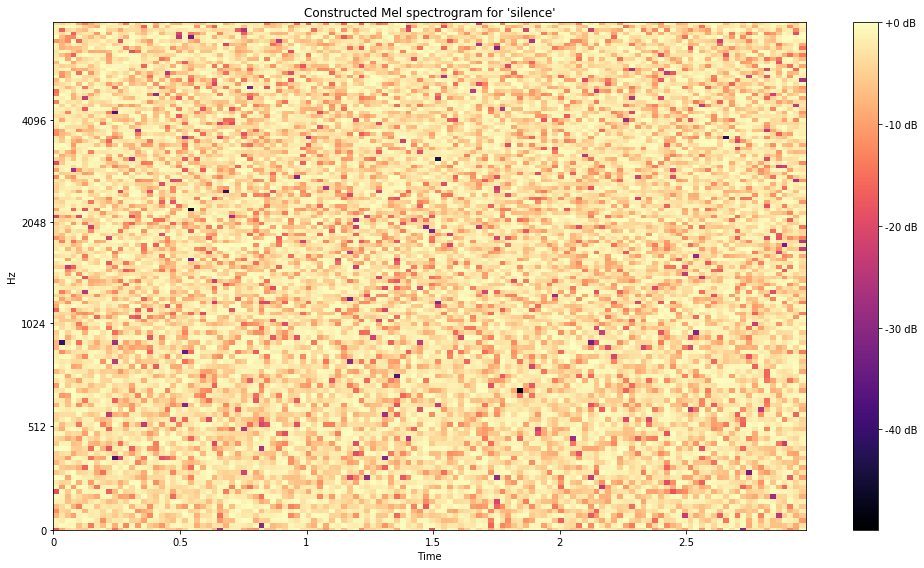

In [0]:
plt.figure(figsize=(14, 8))
librosa.display.specshow(librosa.power_to_db(class_img_silence[0], ref=np.max),
                             y_axis='mel', fmax=8000,
                             x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Constructed Mel spectrogram for \'silence\'')
plt.tight_layout()

In [0]:
import math
import scipy

print('You are using librosa version ' + librosa.__version__)

### Citation: https://github.com/lonce/SPSI_Python/blob/master/SPSI_notebook/spsi.ipynb
def spsi(msgram, fftsize, hop_length) :
    """
    Takes a 2D spectrogram ([freqs,frames]), the fft legnth (= widnow length) and the hope size (both in units of samples).
    Returns an audio signal.
    """
    
    numBins, numFrames  = msgram.shape
    y_out=np.zeros(numFrames*hop_length+fftsize-hop_length)
        
    m_phase=np.zeros(numBins);      
    m_win=scipy.signal.hanning(fftsize, sym=True)  # assumption here that hann was used to create the frames of the spectrogram
    
    #processes one frame of audio at a time
    for i in range(numFrames) :
            m_mag=msgram[:, i] 
            for j in range(1,numBins-1) : 
                if(m_mag[j]>m_mag[j-1] and m_mag[j]>m_mag[j+1]) : #if j is a peak
                    alpha=m_mag[j-1];
                    beta=m_mag[j];
                    gamma=m_mag[j+1];
                    denom=alpha-2*beta+gamma;
                    
                    if(denom!=0) :
                        p=0.5*(alpha-gamma)/denom;
                    else :
                        p=0;
                        
                    #phaseRate=2*math.pi*(j-1+p)/fftsize;    #adjusted phase rate
                    phaseRate=2*math.pi*(j+p)/fftsize;    #adjusted phase rate
                    m_phase[j]= m_phase[j] + hop_length*phaseRate; #phase accumulator for this peak bin
                    peakPhase=m_phase[j];
                    
                    # If actual peak is to the right of the bin freq
                    if (p>0) :
                        # First bin to right has pi shift
                        bin=j+1;
                        m_phase[bin]=peakPhase+math.pi;
                        
                        # Bins to left have shift of pi
                        bin=j-1;
                        while((bin>1) and (m_mag[bin]<m_mag[bin+1])) : # until you reach the trough
                            m_phase[bin]=peakPhase+math.pi;
                            bin=bin-1;
                        
                        #Bins to the right (beyond the first) have 0 shift
                        bin=j+2;
                        while((bin<(numBins)) and (m_mag[bin]<m_mag[bin-1])) :
                            m_phase[bin]=peakPhase;
                            bin=bin+1;
                            
                    #if actual peak is to the left of the bin frequency
                    if(p<0) :
                        # First bin to left has pi shift
                        bin=j-1;
                        m_phase[bin]=peakPhase+math.pi;

                        # and bins to the right of me - here I am stuck in the middle with you
                        bin=j+1;
                        while((bin<(numBins)) and (m_mag[bin]<m_mag[bin-1])) :
                            m_phase[bin]=peakPhase+math.pi;
                            bin=bin+1;
                        
                        # and further to the left have zero shift
                        bin=j-2;
                        while((bin>1) and (m_mag[bin]<m_mag[bin+1])) : # until trough
                            m_phase[bin]=peakPhase;
                            bin=bin-1;
                            
                #end ops for peaks
            #end loop over fft bins with

            magphase=m_mag*np.exp(1j*m_phase)  #reconstruct with new phase (elementwise mult)
            magphase[0]=0; magphase[numBins-1] = 0 #remove dc and nyquist
            m_recon=np.concatenate([magphase,np.flip(np.conjugate(magphase[1:numBins-1]), 0)]) 
            
            #overlap and add
            m_recon=np.real(np.fft.ifft(m_recon))*m_win
            y_out[i*hop_length:i*hop_length+fftsize]+=m_recon
            
    return y_out

You are using librosa version 0.6.3


In [0]:
class_img_silence[0].shape

(128, 128)

In [0]:
y_out = spsi(class_img_silence[0], fftsize=2048, hop_length=512) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!


ValueError: ignored

In [0]:
p = np.angle(librosa.stft(y_out, fftsize, hop_length, center=False))
for i in range(50):
    S = magD * np.exp(1j*p)
    x = librosa.istft(S, hop_length, center=True) # Griffin Lim, assumes hann window; librosa only does one iteration?
    p = np.angle(librosa.stft(x, fftsize, hop_length, center=True))

IPython.display.Audio(data=x, rate=sr)

In [0]:
recovered_audio_orig = invert_pretty_spectrogram(wav_spectrogram, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=recovered_audio_orig, rate=rate) # play the audio

In [0]:
model.fit(spec_100[:train_idx],onehot_labels[:train_idx], validation_data = (spec_100[train_idx:], onehot_labels[train_idx:]), epochs = 3\
         ,batch_size = 16)


Instructions for updating:
Use tf.cast instead.
Train on 9296 samples, validate on 2324 samples
Epoch 1/3
9296/9296 [==============================] - 374s 40ms/step - loss: 2.2151 - acc: 0.2215 - val_loss: 2.0827 - val_acc: 0.2685
Epoch 2/3
1520/9296 [===>..........................] - ETA: 4:52 - loss: 1.9536 - acc: 0.2901

KeyboardInterrupt: ignored

In [0]:
predictions = model.predict(spec_100[train_idx:])

In [0]:
model.save_weights(dir_prefix + "/models/2d_cnn_draft_model.h5")
model_json = model.to_json()
with open("/models/2d_cnn_draft_model.json", "w") as json_file:
    json_file.write(model_json)
    

OSError: ignored

In [0]:
spec_100[train_idx:].shape

(2324, 128, 128, 1)

In [0]:
from sklearn.metrics import f1_score

pred = np.argmax(predictions,axis=1).flatten()
gold = np.argmax(onehot_labels[train_idx:],axis=1).flatten()

f1_score(gold, pred, average = None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.        , 0.05291005, 0.35887097, 0.        , 0.        ,
       0.01574803, 0.        , 0.        , 0.48514851, 0.22771536,
       0.13554633])

In [0]:
f1_score(gold, pred, average = 'micro')

0.22719449225473323

In [0]:
encoder.inverse_transform(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]).reshape(1,11))

array([['solo']], dtype='<U12')

### Fitting data into basic 2D CNN model with [128,4]

In [0]:

m = Sequential()
m.add(Conv2D(64, (1, 4), input_shape=(1, 128, 128)))
m.add(Activation('relu'))
m.add(MaxPooling2D(pool_size=(1,4)))

m.add(Conv2D(32, (1, 4)))
m.add(Activation('relu'))
m.add(MaxPooling2D(pool_size=(1, 4)))

m.add(Flatten())
m.add(Dense(onehot_labels.shape[1], activation = 'softmax'))
#model.add(Dropout(0.5))

m.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1, 125, 64)        32832     
_________________________________________________________________
activation_15 (Activation)   (None, 1, 125, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 31, 64)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 28, 32)         8224      
_________________________________________________________________
activation_16 (Activation)   (None, 1, 28, 32)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 7, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 224)               0         
__________

In [0]:
m.fit(spec[:41126],onehot_labels[:41126], validation_data = (spec[41126:], onehot_labels[41126:]), epochs = 1\
         ,batch_size = 16)

Train on 41126 samples, validate on 10282 samples
Epoch 1/1
41126/41126 [==============================] - 258s 6ms/step - loss: 2.2982 - acc: 0.2643 - val_loss: 1.9879 - val_acc: 0.2697


### Fitting data into 1D CNN model + BatchNorm + Dropout

In [0]:
spec = spec.reshape(51408,128,128)

In [0]:
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization

f_size = 5
p_size = 2


model2 = Sequential()
model2.add(Conv1D(64, f_size, input_shape=(128, 128)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(p_size))
model2.add(Dropout(rate = 0.2))


model2.add(Conv1D(32, f_size))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(p_size))
model2.add(Dropout(rate = 0.2))

model2.add(Flatten())
model2.add(Dense(onehot_labels.shape[1], activation = 'softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
spec_t = spec.reshape(51408,128,128).transpose([0, 2, 1])

In [0]:
model2.fit(spec_t[:41126],onehot_labels[:41126], validation_data = (spec_t[41126:], onehot_labels[41126:]), epochs = 1\
         ,batch_size = 16)

Train on 41126 samples, validate on 10282 samples
Epoch 1/1
41126/41126 [==============================] - 272s 7ms/step - loss: 2.0280 - acc: 0.2924 - val_loss: 2.0030 - val_acc: 0.3159


In [0]:
predictions2 = model2.predict(spec[41126:]) 
pred2 = np.argmax(predictions2,axis=1).flatten()
gold2 = np.argmax(onehot_labels[41126:],axis=1).flatten()

f1_score(gold2, pred2, average = None)

/anaconda2/envs/cs28/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.        , 0.12553648, 0.        , 0.        , 0.        ,
       0.00476758, 0.44605309, 0.        , 0.        , 0.46983492,
       0.17055988])

In [0]:
f1_score(gold2, pred2, average = 'micro')

0.3252285547558841

### Fitting data into 2D CNN model + TimeDistributed Layer

In [0]:
from keras.layers import TimeDistributed
from keras.layers import LSTM



model3 = Sequential()
model3.add(TimeDistributed(Conv2D(64, (3, 3), activation = 'relu', \
        data_format='channels_first'), input_shape=(7, 1, 128, 128)))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model3.add(TimeDistributed(BatchNormalization()))

model3.add(TimeDistributed(Conv2D(32, (3,3), activation = 'relu')))
model3.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model3.add(TimeDistributed(BatchNormalization()))

model3.add(TimeDistributed(Flatten()))
model3.add(LSTM(256, return_sequences  = True))
model3.add(Dense(onehot_labels.shape[2], activation = 'softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
spec.shape

(7344, 7, 1, 128, 128)

In [0]:
spec = spec.reshape(7344,7,1,128,128)
spec.shape

(7344, 7, 1, 128, 128)

In [0]:
onehot_labels = onehot_labels.reshape(7344,7,11)
onehot_labels.shape

(7344, 7, 11)

In [0]:
model3.fit(spec[:6000],onehot_labels[:6000], validation_data = (spec[6000:], onehot_labels[6000:]), epochs = 5\
         ,batch_size = 16)
model3.save('cnn_lstm.h5')


Train on 6000 samples, validate on 1344 samples
Epoch 1/5
6000/6000 [==============================] - 3174s 529ms/step - loss: 1.9714 - acc: 0.3090 - val_loss: 2.0470 - val_acc: 0.2665
Epoch 2/5
6000/6000 [==============================] - 3034s 506ms/step - loss: 1.9159 - acc: 0.3286 - val_loss: 2.0660 - val_acc: 0.2761
Epoch 3/5
6000/6000 [==============================] - 2995s 499ms/step - loss: 1.8905 - acc: 0.3427 - val_loss: 2.0089 - val_acc: 0.3142
Epoch 4/5
6000/6000 [==============================] - 2954s 492ms/step - loss: 1.8521 - acc: 0.3577 - val_loss: 1.9809 - val_acc: 0.3337
Epoch 5/5
6000/6000 [==============================] - 2930s 488ms/step - loss: 1.8244 - acc: 0.3729 - val_loss: 1.9556 - val_acc: 0.3485


In [0]:
with open('purple_rain.p', 'rb') as f:
    rain = pickle.load(f)
rain = np.asarray(rain).reshape(26,7,1,128,128)

In [0]:
pred = model3.predict(rain)
pred.shape

(26, 7, 11)

In [0]:
encoder.inverse_transform(pred.reshape(26*7,11))

array([['verse'],
       ['verse'],
       ['verse'],
       ['verse'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['verse'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['chorus'],
       ['verse'],
       ['verse'],
       ['solo'],
       ['verse'],
       ['verse'],
       ['solo'],
       ['verse'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['chorus'],
       ['chorus'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['chorus'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['chorus'],
       ['chorus'],
       ['chorus'],
       ['solo'],
       ['chorus'],
       ['solo'],
       ['solo'],
       ['chorus'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
       ['solo'],
   

In [0]:
i = model3.predict(spec[6000:])
i.shape

(1344, 7, 11)

In [0]:
1344* 7

9408

In [0]:
k = np.argmax(i.reshape(9408,11), axis = 1)
k = OneHotEncoder(sparse = False).fit_transform(k.reshape(-1,1))

/anaconda2/envs/cs28/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
gold = onehot_labels[6000:].reshape(9408,11)

f1_score(gold, k, average = None)

array([0.        , 0.20017873, 0.        , 0.        , 0.01617251,
       0.        , 0.50726141, 0.00481928, 0.68410463, 0.47247104,
       0.25583567])

In [0]:
k = encoder.inverse_transform(k)
gold = encoder.inverse_transform(gold)

In [0]:
len(k)

9408

In [0]:
#from sklearn.metrics import multilabel_confusion_matrix
#mx = multilabel_confusion_matrix(ground_truth, pred, labels = classes)
import pandas as pd

classes = ['instrumental', 'interlude', 'bridge', 'chorus', 'verse', 
           'intro', 'silence', 'no_function', 'outro', 'misc', 
           'solo']

def compute_confusion_matrix(pred, label, classes):
  evaluation = {}
  for c1 in classes:
    for c2 in classes:
      if c1 not in evaluation:
        evaluation[c1] = { 
        'TP': 0,
        'FP': {},
        'FN': {}
        }
      if c1 != c2:
        evaluation[c1]['FP'][c2] = 0
        evaluation[c1]['FN'][c2] = 0
        
  for l, p in zip(label, pred):
    l = l[0]
    p = p[0]

    if l == p:
      evaluation[l]['TP'] += 1
    else:
      ## if missed the label
      
      evaluation[l]['FN'][p] += 1 

      evaluation[p]['FP'][l] += 1

  num_class = len(evaluation)
  confusion_mx = np.zeros((num_class, num_class))
  for i, key in enumerate(evaluation.keys()):
    for j, key2 in enumerate(evaluation.keys()):
      if i == j:
        confusion_mx[i,j] = evaluation[key]['TP']
      elif i < j:
        confusion_mx[i,j] = evaluation[key]['FN'][key2]
      else:
        
        confusion_mx[i,j] = evaluation[key2]['FP'][key]

  recall = np.diag(confusion_mx) / np.sum(confusion_mx, axis = 1)
  precision = np.diag(confusion_mx) / np.sum(confusion_mx, axis = 0)
  return confusion_mx, recall, precision




In [0]:
cm, r, p = compute_confusion_matrix(k, gold, classes)

In [0]:
cm_df.shape

(11, 11)

Normalized confusion matrix


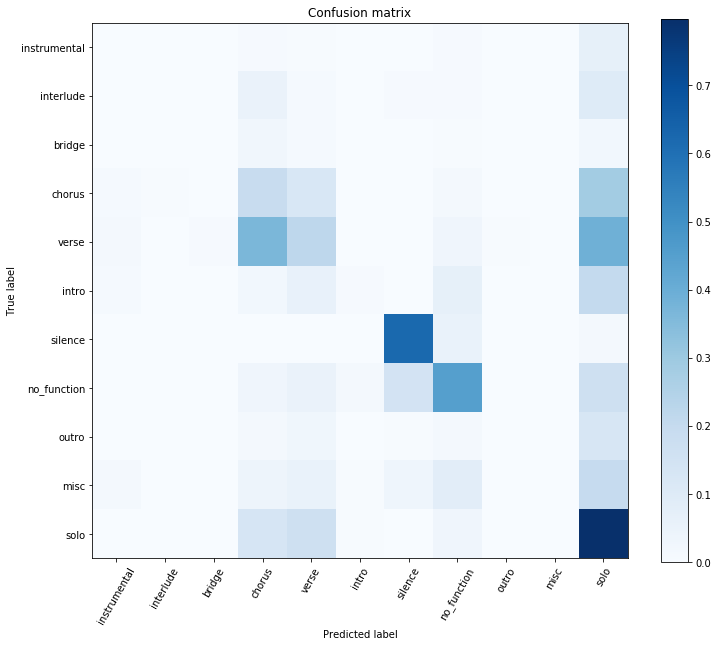

In [0]:

cm_df = pd.DataFrame(cm)
normalize = True
if normalize:
    cm_df2 = cm_df.astype('float') / cm_df.sum(axis=1)#[:, np.newaxis]
    print("Normalized confusion matrix")
    
plt.figure(figsize=(12,10))
plt.imshow(cm_df2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Attention-based Model

In [0]:
%reload_ext autoreload
%autoreload 2

from attention_2d import *

In [0]:
cnn_config = {'cnn_regularization': 0.01,
			  'fc_regularization': 0.01}

att_config = {'num_class': 11,
			  'att_input_dim': 64,
			  'sequence_len':7
				}

train_config = {}

m = CNN_Attention_Model(cnn_config, att_config, train_config)
built = m.build_model()
built.summary()

##### Tensor("input_6:0", shape=(?, 1, 128, 128), dtype=float32)
##### Tensor("max_pooling2d_42/transpose_1:0", shape=(?, 32, 30, 30), dtype=float32)
#### Tensor("flatten_25/Reshape:0", shape=(?, ?), dtype=float32)
#### Tensor("dense_29/Relu:0", shape=(?, 64), dtype=float32)
#### Tensor("lambda_8/Reshape:0", shape=(?, 7, 64), dtype=float32)
### att output: Tensor("seq_self_attention_6/MatMul_3:0", shape=(?, ?, 64), dtype=float32)
#### output: Tensor("dense_30/add:0", shape=(?, 7, 11), dtype=float32)
#### folded output: Tensor("lambda_9/Reshape:0", shape=(?, 11), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 128, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 128, 128)      1088      
_________________________________________________________________
max_pooling2d_41 (Ma

In [0]:
spec = spec.reshape(51408, 1, 128, 128)
onehot_labels, encoder = onehot_reshape_labels(labels)
onehot_labels.shape

(7344, 7, 11)

In [0]:
onehot_labels = onehot_labels.reshape(-1,11)
onehot_labels.shape

(51408, 11)

In [0]:
built.fit(spec[:41125],onehot_labels[:41125], validation_data = (spec[41125:], onehot_labels[41125:]), epochs = 1\
         ,batch_size = 16*7)

Train on 41125 samples, validate on 10283 samples
Epoch 1/1
 1680/41125 [>.............................] - ETA: 1:14:30 - loss: 8.5820 - categorical_accuracy: 0.1940

KeyboardInterrupt: 

### Fitting Data in CNN-BiLSTM Model

In [0]:
K = 7
num_classes = len(np.unique(argmax_labels))

tf.reset_default_graph()

cnn_config = {'filter_config': {'filter_size': [4, 4],
                                'num_filter': [5, 10],
                                'pool_size': [4, 4],
                                'pool_stride': [2, 2]
                                },
              'regularization': 0.01,
              'cnn_dropout': 0.8,
              'fc_regularization': 0.01}

bilstm_config = {'input_dim': 64,
                 'output_dims': [32, 16, num_classes],## 6 being the num_of_classes TODO: what could be a better choice of size 
                 'sequence_len': K,
                 'lstm_dropout': 0.8} 

train_config = {'grad_clipping': False}
model = CNN_biLSTM_Model(cnn_config, bilstm_config, train_config)
model.build()


batch_size = 8
epoch = 1

model.train(spec[:2000], argmax_labels[:2000] , epoch, batch_size, learning_rate = 5e-4, model_name = 'test')


##### Tensor("fc/Shape:0", shape=(2,), dtype=int32)
##### loss after reduce mean: Tensor("Mean:0", shape=(), dtype=float32)
num_batch  250
Training loss at epoch 0 batch 0: 3.090580
Training loss at epoch 0 batch 5: 3.087629
Training loss at epoch 0 batch 10: 3.087631
Training loss at epoch 0 batch 15: 3.090193
Training loss at epoch 0 batch 20: 3.087160
Training loss at epoch 0 batch 25: 3.086078
Training loss at epoch 0 batch 30: 3.083530
Training loss at epoch 0 batch 35: 3.080720
Training loss at epoch 0 batch 40: 3.083870
Training loss at epoch 0 batch 45: 3.086091
Training loss at epoch 0 batch 50: 3.077889
Training loss at epoch 0 batch 55: 3.074372
Training loss at epoch 0 batch 60: 3.075760
Training loss at epoch 0 batch 65: 3.070809
Training loss at epoch 0 batch 70: 3.079123
Training loss at epoch 0 batch 75: 3.073577
Training loss at epoch 0 batch 80: 3.065514
Training loss at epoch 0 batch 85: 3.067707
Training loss at epoch 0 batch 90: 3.061091
Training loss at epoch 0 ba

In [0]:
pred = model.predict(spec[1800:2000].reshape(1400,1,128,128), argmax_labels[1800:2000], 'test')

INFO:tensorflow:Restoring parameters from test


In [0]:
np.unique(pred)

array([ 0,  1,  5,  6,  9, 10])

In [0]:
np.unique(argmax_labels[1800:2000])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [0]:
encoder.inverse_transform(np.unique(argmax_labels[1800:2000]))

array(['chorus', 'instrumental', 'interlude', 'intro', 'misc',
       'no_function', 'outro', 'silence', 'solo', 'verse'], dtype='<U12')

In [0]:
from sklearn.metrics import f1_score

gold = argmax_labels[2000:2200].flatten()
pred = pred.flatten()

f1_score(gold, pred, average = None)

array([0.        , 0.00692042, 0.        , 0.        , 0.        ,
       0.        , 0.05882353, 0.        , 0.        , 0.33483348,
       0.25603865])

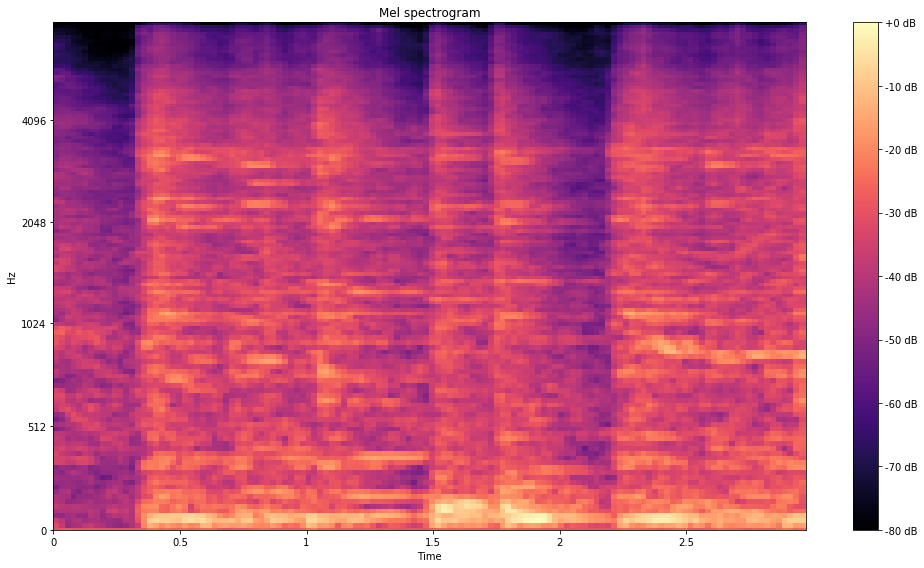

In [0]:
plt.figure(figsize=(14, 8))
librosa.display.specshow(librosa.power_to_db(spec[0][0], ref=np.max),
                             y_axis='mel', fmax=8000,
                             x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

### Create class image


In [0]:
random_frame = np.random.rand(1,128,128)